LLM model GPT-2

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [2]:
import torch 
import torch.nn as nn

ln = nn.LayerNorm(GPT_CONFIG_124M["emb_dim"])
gelu = nn.GELU()

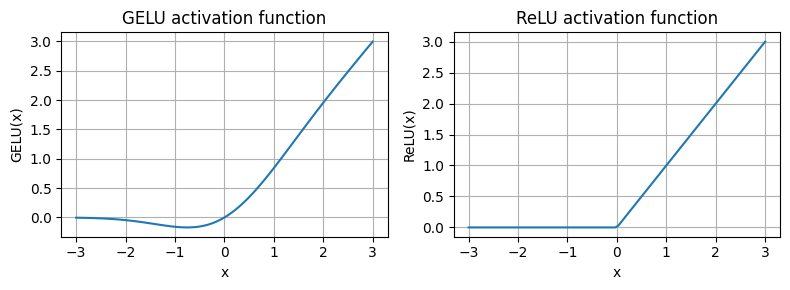

In [4]:
import matplotlib.pyplot as plt

gelu = nn.GELU()
relu = nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.emd_dim = cfg["emb_dim"]
        self.layers = nn.Sequential(
            nn.Linear(self.emd_dim, 4*self.emd_dim),
            nn.GELU(),
            nn.Linear(4*self.emd_dim, self.emd_dim)
        )

    def forward(self, x):
        return self.layers(x)

Transformer Block 

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.ln1 = nn.LayerNorm(cfg["emb_dim"])
        self.ln2 = nn.LayerNorm(cfg["emb_dim"])
        self.attn = MultiHeadAttention(cfg["emb_dim"], cfg["emb_dim"], cfg["context_length"], cfg["drop_rate"], cfg["n_heads"], cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.dropout = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.ln1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = shortcut + x

        shortcut = x
        x = self.ln2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = shortcut + x
        return x

In [14]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [17]:
class GPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_ln = nn.LayerNorm(cfg["emb_dim"])
        self.out_proj = nn.Linear(cfg["emb_dim"], cfg["vocab_size"])

    def forward(self, x):
        batch_size, seq_len = x.shape
        token_emb = self.token_emb(x)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = token_emb + pos_emb
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_ln(x)
        logits = self.out_proj(x)
        return logits
    

In [18]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.1003, -0.0792,  0.2678,  ..., -0.1807,  0.2391, -0.4863],
         [ 0.4848, -0.4641, -1.0275,  ..., -0.7874, -0.0726, -0.6351],
         [ 0.8252, -0.3753,  0.2049,  ...,  0.0482, -0.1148, -0.4465],
         [-0.7435,  0.0080, -0.2567,  ...,  1.1017,  0.2357, -0.6946]],

        [[-0.1180,  0.5838,  0.2284,  ...,  0.2292,  0.1623, -0.2833],
         [ 0.0461,  0.0826,  0.5261,  ...,  0.4088, -0.4591,  0.4855],
         [ 0.7566,  0.8638,  0.0594,  ...,  0.4737, -0.3423, -0.1071],
         [-0.2600, -0.2242,  0.8337,  ...,  0.8817, -0.3104,  0.0489]]],
       grad_fn=<ViewBackward0>)


In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,059,793


In [20]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 622.02 MB


Generate text function 

In [79]:
def generate_text(model, input_text, context_length, max_new_tokens=100):
    """
    input_text: str, the input text to start the generation [batch, n_tokens]
    context_length: the max length model support 
    max_new_tokens: int, the max number of tokens to generate

    """
    
    for _ in range(max_new_tokens):
        tracated_input = input_text[:, -context_length:]
        with torch.no_grad():
            logits = model(tracated_input) # [batch, n_tokens, vocab_size]
        logits = logits[:, -1, :] # last time sequence is the predicted word 
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        input_text = torch.cat((input_text, idx_next), dim=1)
        print(input_text.shape)

    return input_text


In [80]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [81]:
model.eval() # disable dropout

out = generate_text(
    model,
    encoded_tensor, 
    GPT_CONFIG_124M["context_length"],
    6
)

print("Output:", out)
print("Output length:", len(out[0]))

torch.Size([1, 5])
torch.Size([1, 6])
torch.Size([1, 7])
torch.Size([1, 8])
torch.Size([1, 9])
torch.Size([1, 10])
Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [82]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
